In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Load training data
train_data_import = pd.read_csv("../TrainingData/neodata/fault_all_250.csv")
train_data_import.sample(frac=1).head()

,Pdis,Psuc,T0,Tc,Tdis,Tret,Tsuc,Tsh,Tsup,CondFan,CprPower,Density,Tamb,Tset,target
60529,8.469651,3.832126,7.664156,33.345726,39.426487,22.133008,14.607213,6.943057,12.000045,70.508071,1100.113577,8.441456,30,12,13
94369,12.564006,3.161066,2.132402,48.109855,70.997949,24.397122,16.551811,14.419407,11.997042,30.000000,5671.724946,6.930276,30,12,20
18967,8.088526,2.620943,-3.019364,31.714584,46.428150,5.812679,3.424443,6.443807,0.000008,52.384265,1393.405705,5.880824,20,0,4
12806,8.953024,2.407059,-5.287845,35.336941,59.768898,10.678949,6.750214,12.038059,-0.001024,92.632674,3579.052702,5.365520,30,0,2
76789,7.876105,3.732841,7.044074,30.770772,37.138916,21.219437,20.732626,13.687719,16.220676,41.897461,320.844584,8.129830,10,7,17


----
# Linear Discriminant Analysis of data
----

In [4]:
# Config

train_data = train_data_import.copy()

sigma = 0.001

ignore_features = []
ignore_targets = []

# ignore_features = ["Tamb"]
# ignore_targets = [17,18,19]

features = train_data_import.columns.to_list()
targets = train_data_import['target'].unique().tolist()

# Remove unwanted
for i in ignore_targets:
    targets.remove(i)
    
for i in ignore_features:
    train_data.pop(i)

In [5]:
# Temporarily remove target column
target = train_data.pop('target')

import standardization as sd

stand = sd.standardization(train_data_import,'target')
train_data = stand.transform(train_data_import)

# Add gaussian noise
train_data += np.random.randn(train_data.shape[0],train_data.shape[1])*sigma

# Reapply taget column
train_data = train_data.assign(target=target)

In [6]:
train_data.head()

,Pdis,Psuc,T0,Tc,Tdis,Tret,Tsuc,Tsh,Tsup,CondFan,CprPower,Density,Tamb,Tset,target
0,-1.035333,-0.475382,-0.510435,-1.091613,-0.366299,-0.915630,-0.954585,-1.100387,-0.692047,-1.041432,-0.860539,-0.461146,-1.223738,-1.287460,0
1,-1.034436,-0.475785,-0.512036,-1.092275,-0.364843,-0.913904,-0.955818,-1.100155,-0.691388,-1.039732,-0.858773,-0.458460,-1.224859,-1.286623,0
2,-1.037109,-0.475729,-0.511002,-1.093182,-0.366839,-0.913820,-0.954174,-1.100515,-0.690335,-1.040844,-0.858736,-0.462373,-1.225666,-1.287259,0
3,-1.037469,-0.475141,-0.511013,-1.094848,-0.366601,-0.916089,-0.955414,-1.100372,-0.690201,-1.039998,-0.859658,-0.463286,-1.223582,-1.287659,0
4,-1.039060,-0.475307,-0.509735,-1.092322,-0.364386,-0.916550,-0.953509,-1.100973,-0.690881,-1.039817,-0.857803,-0.463799,-1.223552,-1.287346,0


----
# Dimensionality reduction using LDA

Preserving 99.28% of variance


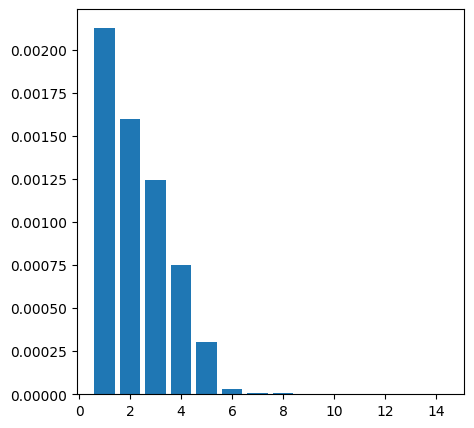

In [7]:
from lda import LDA_reducer as reducer
lda = reducer(train_data,5,'target')

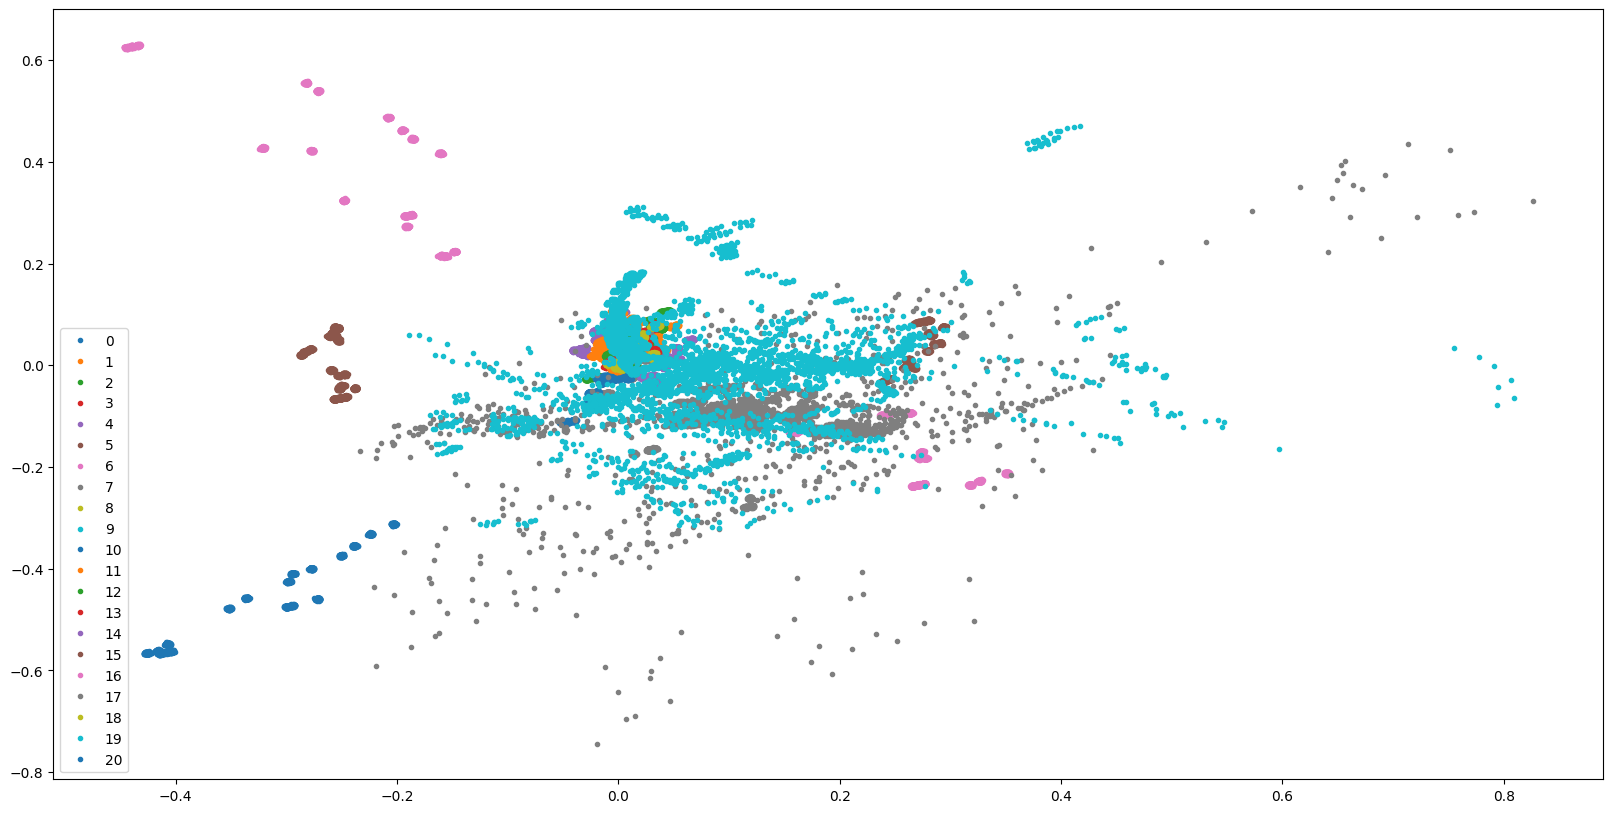

In [8]:
train_z = lda.transform(train_data)

legends = []
plt.figure(figsize=(20,10))
for i in targets:
    plt.plot(train_z[train_z['target'] == i][0],train_z[train_z['target'] == i][1],'.')
    legends.append(int(i))
plt.legend(legends)

In [9]:
# Classify each class' mean and covariance
c = {}
# train_z = train_z.astype('float') # force real
for i in targets:
    c.update({i:{
        "mean" : train_z[train_z['target']==i].drop('target',axis=1).mean().to_numpy(),
        "cov" : train_z[train_z['target']==i].drop('target',axis=1).cov().to_numpy(),
        }})

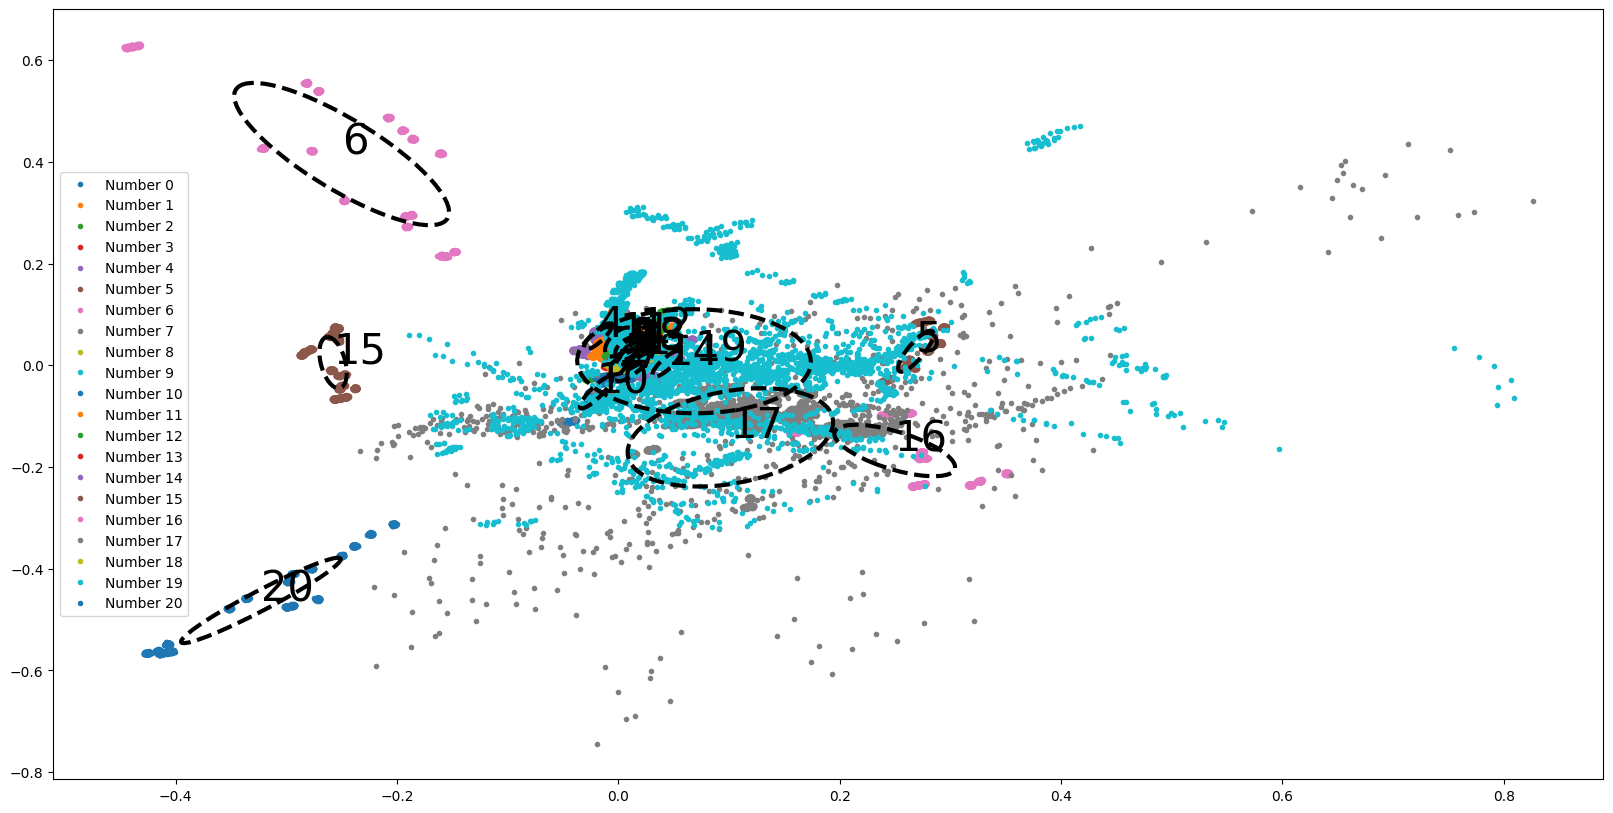

In [10]:
# Plot of training data in lower dim
import std
fig , axs = plt.subplots(figsize=(20,10))
lgnd = []
for i in targets:
    subdf = train_z[train_z['target'] == i]
    axs.plot(np.real(subdf[0]),np.real(subdf[1]),'.')
    axs.text(c[i]["mean"][0],c[i]["mean"][1],i,fontsize=30)
    lgnd.append(i)
axs.legend(["Number "+str(x) for x in lgnd ])
for i in targets:
    std.std_dev(c[i]["mean"],c[i]["cov"],1,axs)

In [11]:
from scipy.stats import multivariate_normal as mvn
from numpy import real

# Run classification
correct = [0 for x in range(len(targets))]
incorrects = []

test_z = train_z.sample(frac=0.05)

conf_matrix = np.zeros((len(targets),len(targets)))

for sample in test_z.iterrows():
    # Find the argument with the highest 
    if sample[1]['target'] in targets:
        arg = np.argmax([mvn.pdf(real(sample[1].drop('target')),real(c[n]["mean"]),real(c[n]["cov"])) for n in targets])
        guess = targets[arg]
        
        conf_matrix[targets.index(int(sample[1]['target'])),int(arg)] += 1

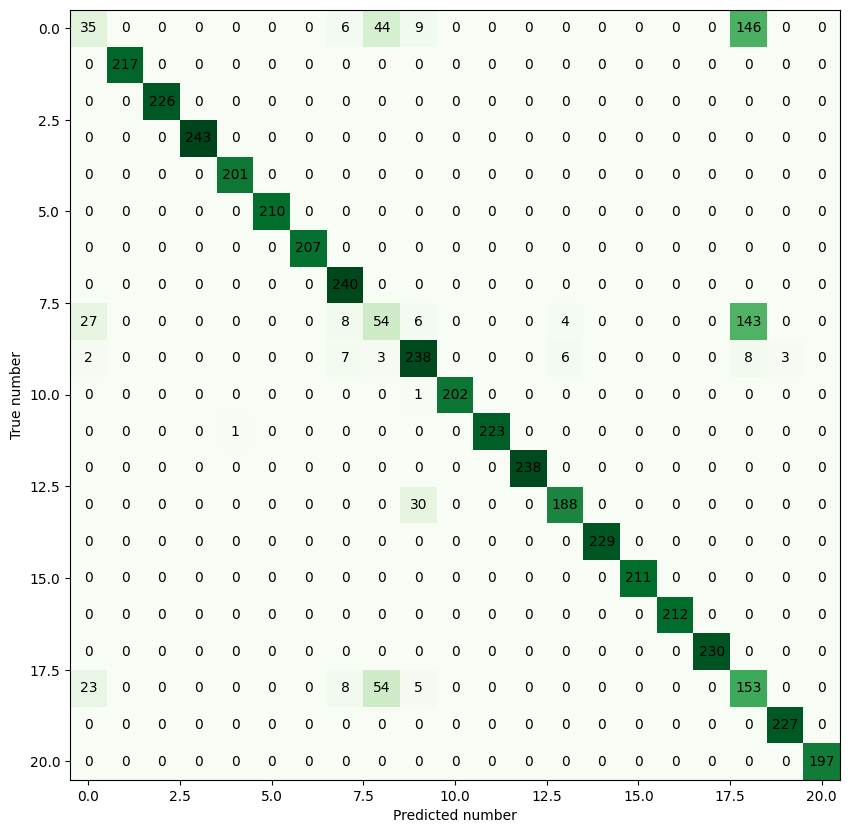

In [12]:
fig , axs = plt.subplots(figsize=(10,10))
axs.imshow(conf_matrix,cmap="Greens")
axs.set_xlabel("Predicted number")
axs.set_ylabel("True number")

width, height = conf_matrix.shape

for x in range(width):
    for y in range(height):
        axs.annotate(str(int(conf_matrix[x][y])), xy=(y, x), 
            horizontalalignment='center',
            verticalalignment='center')

In [13]:
# Print results
for i in targets:
    id = targets.index(i)
    corr = correct[targets.index(i)]
    total = len(test_z[test_z['target'] == i])
    print(f"{i} : \t{int(conf_matrix[id,id])}/{int(sum(conf_matrix[id,:]))}\t {round(conf_matrix[id,id]/sum(conf_matrix[id,:])*100,3)}%")
    
tot_corr = int(sum([conf_matrix[targets.index(x),targets.index(x)] for x in targets]))
tot = int(len(test_z))
    
print(f"TOT : \t{tot_corr}/{tot}\t {round((tot_corr/tot)*100,3)}%")

0 : 	35/240	 14.583%
1 : 	217/217	 100.0%
2 : 	226/226	 100.0%
3 : 	243/243	 100.0%
4 : 	201/201	 100.0%
5 : 	210/210	 100.0%
6 : 	207/207	 100.0%
7 : 	240/240	 100.0%
8 : 	54/242	 22.314%
9 : 	238/267	 89.139%
10 : 	202/203	 99.507%
11 : 	223/224	 99.554%
12 : 	238/238	 100.0%
13 : 	188/218	 86.239%
14 : 	229/229	 100.0%
15 : 	211/211	 100.0%
16 : 	212/212	 100.0%
17 : 	230/230	 100.0%
18 : 	153/243	 62.963%
19 : 	227/227	 100.0%
20 : 	197/197	 100.0%
TOT : 	4181/4725	 88.487%
